# Face Generation

In this project, I'll define and train a DCGAN on a dataset of faces. The goal is to get a generator network to generate *new* images of faces that look as realistic as possible!


In this notebook, I'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored in 2016 and has seen impressive results in generating new images; you can read the [original paper, here](https://arxiv.org/pdf/1511.06434.pdf).


## 0. Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.


## 1. Pre-processed Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

In [1]:
# Download necessary files and datasets for the project
from IPython.display import clear_output

!wget -cq -O problem_unittests.py https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/project-face-generation/problem_unittests.py
!wget -cq -O processed_celeba_small.zip https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip
clear_output()  
print("Downloaded Successfully")

Downloaded Successfully


In [2]:
# Extract data downloaded
# Extractting the dataset
!unzip -n processed_celeba_small.zip
clear_output()
print("Extracted Successfully & Ready!")

Extracted Successfully & Ready!


In [0]:
data_dir = 'processed_celeba_small/'


import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## 2. Visualize the CelebA Data

### 2.1 Pre-process and Load the Data


In [0]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [0]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])

    # define datasets using ImageFolder
    dataset = datasets.ImageFolder(data_dir, transform)

    # create and return DataLoader
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers = 4)

    return data_loader


## 3. Create a DataLoader

Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.


In [0]:
# Define function hyperparameters
batch_size = 32
img_size = 32


# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Let's view some images

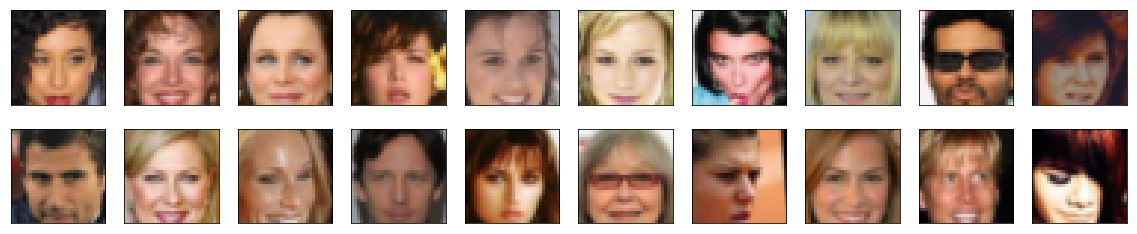

In [7]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

### 3.1 Pre-process and scale images
Images should be scaled to a pixel range of -1 to 1

In [0]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [9]:

# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9529)
Max:  tensor(0.9373)


---
---
# 4. Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.


<img src='assets/model.png' width=60% />


Image credit [Udacity](http://eu.udacity.com). Note image above is from a DCGAN trained using SVNH dataset, here we'll try to replicate the structure using a new dataset

## 4.1 Discriminator

<img src='assets/conv_discriminator.png' width=60% />


Image credit [Udacity](http://eu.udacity.com).


In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [12]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out

tests.test_discriminator(Discriminator)

Tests Passed


## 4.2 Generator

The generator should upsample an input and generate a *new* image of the same size as the training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

<img src='assets/conv_generator.png' width=60% />


Image credit [Udacity](http://eu.udacity.com)

In [0]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [14]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        
        # complete init function
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)

        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
                # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = torch.tanh(out)
        
        return out


tests.test_generator(Generator)

Tests Passed


## 4.3 Initialize the weights of your networks

To help the models conerge, I shall initialize weights of the convolutiona nad linear layers of the model folling the  [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), indications:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.



In [0]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if  hasattr(m.bias, 'data'):
            nn.init.constant_(m.bias.data, 0.0)
    

## 4.4 Build complete network



In [0]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


### 4.4.1 Exercise: Define model hyperparameters

In [17]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 150

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=150, out_features=4096, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

### 4.4.2 Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [18]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## 4.5 Discriminator and Generator Losses

Now I need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

* For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. I set it up so that he output 1 is for real imges and 0 for fake images. 


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.
*

In [0]:
def real_loss(D_out,smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    
    # move labels to GPU if available    
    if train_on_gpu:
        labels = labels.cuda()
        
    # binary cross entropy with logits loss    
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## 4.6 Optimizers


In [0]:
import torch.optim as optim

# Optimizers
lr = 0.0002
beta1=0.3
beta2=0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## 5. Training


#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [0]:
def train(D, G, n_epochs, print_every=300):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_loss = d_optimizer.zero_grad()
            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
         
            # 2. Train the generator with an adversarial loss
            g_loss = g_optimizer.zero_grad()
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

        
    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Let's start training the GAN!

In [22]:
# set number of epochs 
n_epochs = 10


# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   10] | d_loss: 1.7525 | g_loss: 0.6599
Epoch [    1/   10] | d_loss: 0.4718 | g_loss: 1.7989
Epoch [    1/   10] | d_loss: 0.7609 | g_loss: 1.8625
Epoch [    1/   10] | d_loss: 1.0055 | g_loss: 1.6271
Epoch [    1/   10] | d_loss: 0.9756 | g_loss: 1.8359
Epoch [    1/   10] | d_loss: 1.0442 | g_loss: 1.6229
Epoch [    1/   10] | d_loss: 1.3221 | g_loss: 1.0500
Epoch [    1/   10] | d_loss: 0.9551 | g_loss: 0.8347
Epoch [    1/   10] | d_loss: 1.0874 | g_loss: 0.9858
Epoch [    1/   10] | d_loss: 1.1540 | g_loss: 0.7316
Epoch [    2/   10] | d_loss: 1.1963 | g_loss: 0.7171
Epoch [    2/   10] | d_loss: 0.7960 | g_loss: 1.9215
Epoch [    2/   10] | d_loss: 1.1380 | g_loss: 0.9543
Epoch [    2/   10] | d_loss: 0.9518 | g_loss: 1.0115
Epoch [    2/   10] | d_loss: 1.1398 | g_loss: 1.2930
Epoch [    2/   10] | d_loss: 0.8057 | g_loss: 1.8489
Epoch [    2/   10] | d_loss: 1.2619 | g_loss: 1.8210
Epoch [    2/   10] | d_loss: 0.8210 | g_loss: 1.3141
Epoch [    2/   10] | d_loss

### 5.1Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

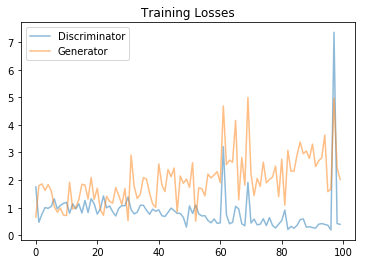

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## 6. Generator samples from training

THe following code will display some images from the Generator, starting with the first and ending with the last images created. 

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [0]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

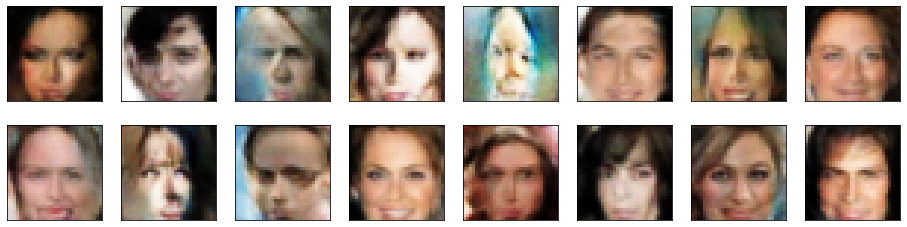

In [26]:
#view first images created at iteration 1
_= view_samples(1, samples)

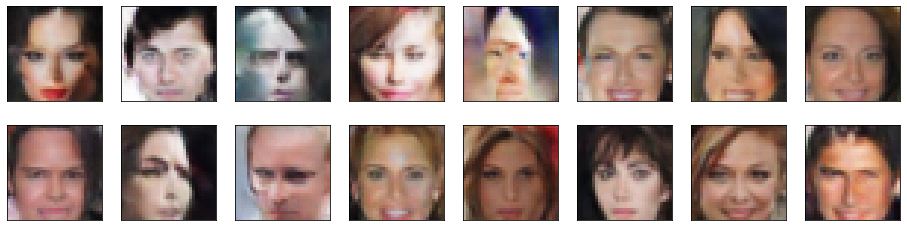

In [27]:
#View last images created
_ = view_samples(-1, samples)

## 7 Opportunity for improvement  


* The dataset is biased 

If we look at the source dataset  [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)  , we shall realize the number of dark skin celebrities is very small. In other words, there are more white/ clear skin celebrities than darker skin celebrities. Therefore, the results will be biased. 

I guess a way to solve this problem would be to increase the number of dark skin celebrities in the dataset, perhaps by adding more pictures. I ignore if there's any equivalent to smote for this when it comes to images, I guess there is not. Thus, the best way to improve this would be to increase the number of pictures of the minority class by adding more pictures. 

* Model size

True, the size of the pictures 32 x 32 x 3 is really small, and thus the model capacity to learn features from such a small dataset is limited. Having larger images would allow the model to learn better the features and generate higher quality faces. The trade off here would be time, higher quality images on the data set would imply a larger training time. 

* Optimization strategy 

Hyperparmeter selection: (I started with those parameters suggested on DCGAN paperr and then I would modify them).
 
Initially I played with only different learning rates, 0.0005, 0.0004,0.0004,0.0003, so I finally decided the best was the initial one (same as DCGAN paper)
Then I decreased the batch size from 182 to 32 (trying different values between 64 and 10), increased the z_size to 150 and the d_conv and g_conv from 32 to 64

As a result, Generator and Discriminator trainning losses converged better. 

Probably, using Transfer learning for encoding and decoding images, could have provided a better result.
